## Monthly Milk Production Forecasting Using RNN, LSTM, and GRU Deep Learning Models

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



## 1.Exploratory Data Analysis (EDA)

In [12]:
df=pd.read_csv('monthly_milk_production.csv')
df.shape

(168, 2)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [14]:
# checking for missing values
df.isnull().sum()

Date          0
Production    0
dtype: int64

In [15]:
# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Rename column for convenience
df.rename(columns={'Production': 'milk_production'}, inplace=True)

# Basic stats
print(df.describe())


       milk_production
count       168.000000
mean        754.708333
std         102.204524
min         553.000000
25%         677.750000
50%         761.000000
75%         824.500000
max         969.000000


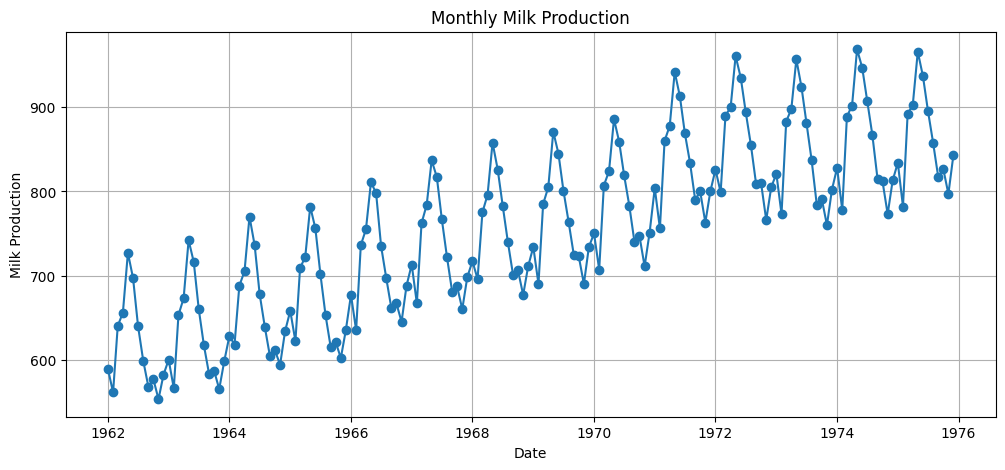

In [19]:
# Plot full time series
plt.figure(figsize=(12,5))
plt.plot(df.index, df['milk_production'], marker='o')
plt.title("Monthly Milk Production")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.grid(True)
plt.show()


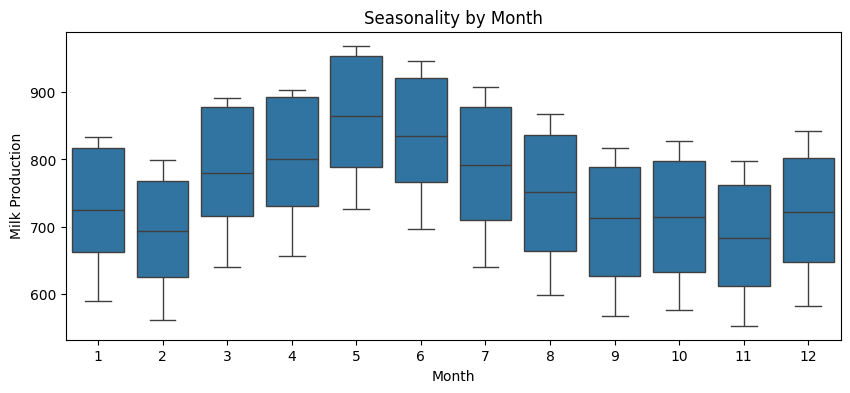

In [ ]:
# Box Plot
df['month'] = df.index.month
plt.figure(figsize=(10,4))
sns.boxplot(x='month', y='milk_production', data=df)
plt.title("Seasonality by Month")
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.show()

# Remove the helper column for modeling
df.drop(columns=['month'], inplace=True)


In [22]:
#Scale the data (MinMax between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df[['milk_production']])

# Convert back to DataFrame to keep index
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=['milk_production'])



## 2.Data Preparation for Deep Learning

In [24]:
# Create sequences (windowed data)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 12  # e.g., use past 12 months to predict next month

values = df_scaled['milk_production'].values
X_all, y_all = create_sequences(values, WINDOW_SIZE)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)


X_all shape: (156, 12)
y_all shape: (156,)


In [25]:
# Train/Validation/Test split (e.g., 70% train, 15% val, 15% test)
total_samples = X_all.shape[0]
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)
test_size = total_samples - train_size - val_size


In [26]:
X_train = X_all[:train_size]
y_train = y_all[:train_size]

X_val = X_all[train_size:train_size+val_size]
y_val = y_all[train_size:train_size+val_size]

X_test = X_all[train_size+val_size:]
y_test = y_all[train_size+val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (109, 12) (109,)
Val  : (23, 12) (23,)
Test : (24, 12) (24,)


In [28]:
# Reshape for RNN/LSTM/GRU (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE, 1))
X_val   = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
X_test  = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))

print("Reshaped X_train:", X_train.shape)


Reshaped X_train: (109, 12, 1)


## 3.Model Building

In [29]:
# model building RNN

def build_rnn_model(window_size, units=32):
    model = keras.Sequential([
        layers.SimpleRNN(units, input_shape=(window_size, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')
    return model


In [30]:
## model building LSTM
def build_lstm_model(window_size, units=32):
    model = keras.Sequential([
        layers.LSTM(units, input_shape=(window_size, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')
    return model


In [31]:
# model building GRU
def build_gru_model(window_size, units=32):
    model = keras.Sequential([
        layers.GRU(units, input_shape=(window_size, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')
    return model

In [32]:
EPOCHS = 80
BATCH_SIZE = 8

rnn_model  = build_rnn_model(WINDOW_SIZE, units=32)
lstm_model = build_lstm_model(WINDOW_SIZE, units=32)
gru_model  = build_gru_model(WINDOW_SIZE, units=32)

print("RNN summary:")
rnn_model.summary()
print("\nLSTM summary:")
lstm_model.summary()
print("\nGRU summary:")
gru_model.summary()


c:\Users\prath\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RNN summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)


LSTM summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)


GRU summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
## Training  all three models

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[early_stop]
)


In [35]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[early_stop]
)



In [36]:
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[early_stop]
)


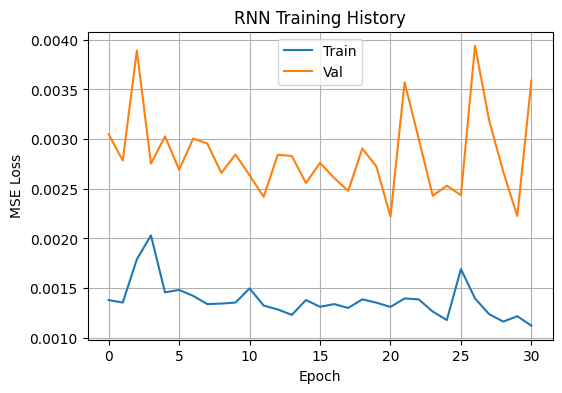

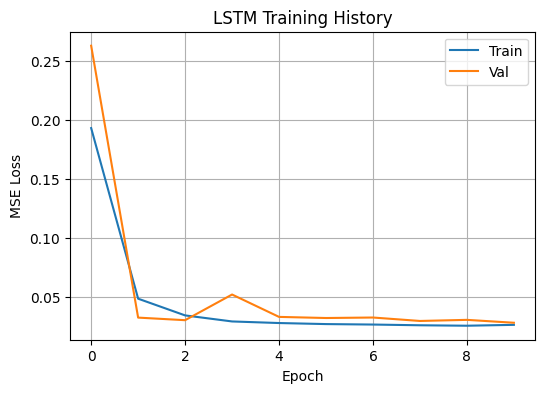

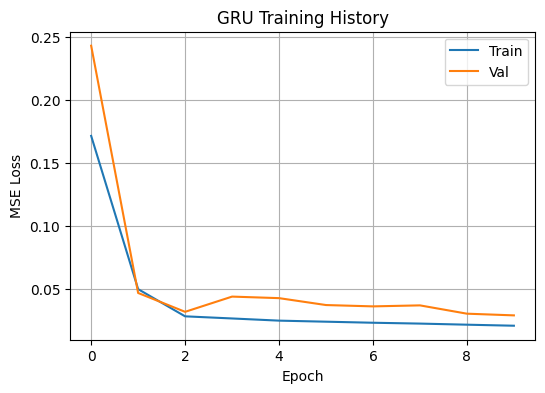

In [37]:
def plot_history(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_rnn, "RNN Training History")
plot_history(history_lstm, "LSTM Training History")
plot_history(history_gru, "GRU Training History")


## 4.Model Evaluation 

In [38]:
def inverse_transform(scaled):
    # scaled is 1D array (predictions or targets in scaled form)
    scaled = np.array(scaled).reshape(-1, 1)
    return scaler.inverse_transform(scaled).ravel()



In [ ]:
def evaluate_forecast(model, X, y, name="Model"):
    y_pred_scaled = model.predict(X)
    y_pred = inverse_transform(y_pred_scaled)
    y_true = inverse_transform(y)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n=== {name} on Test Set ===")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"MAPE: {mape:.2f}%")
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label='Actual', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title(f"{name} – Actual vs Predicted (Test)")
    plt.xlabel("Time index (test)")
    plt.ylabel("Milk Production")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {"rmse": rmse, "mae": mae, "mape": mape}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

=== RNN on Test Set ===
RMSE: 15.866
MAE : 13.006
MAPE: 1.48%


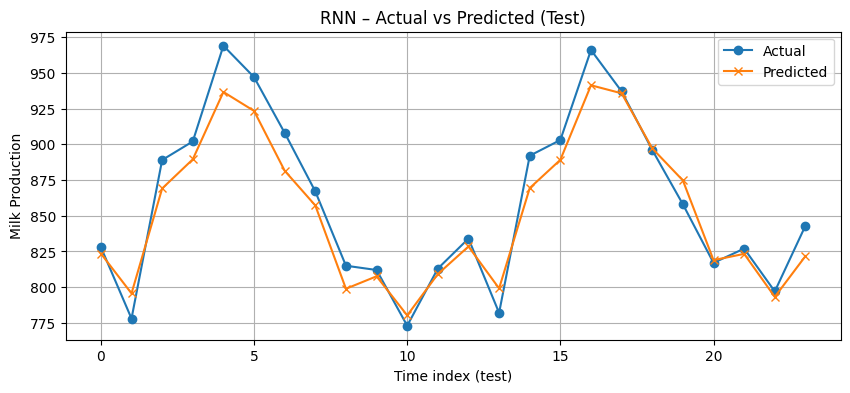

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step

=== LSTM on Test Set ===
RMSE: 222.425
MAE : 213.630
MAPE: 24.46%


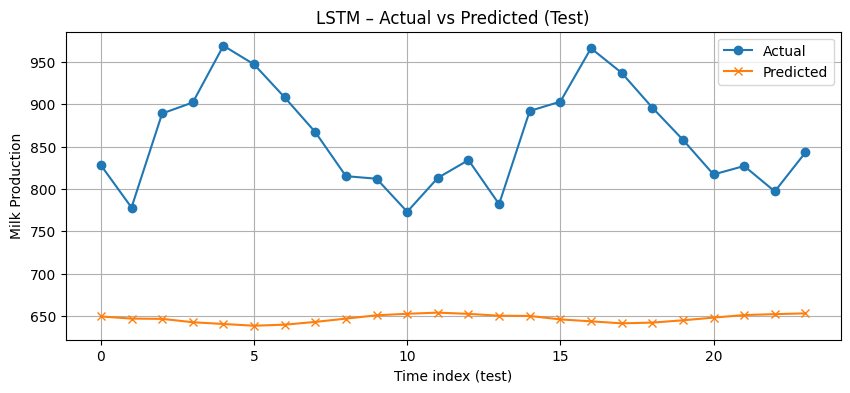

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

=== GRU on Test Set ===
RMSE: 213.999
MAE : 205.686
MAPE: 23.55%


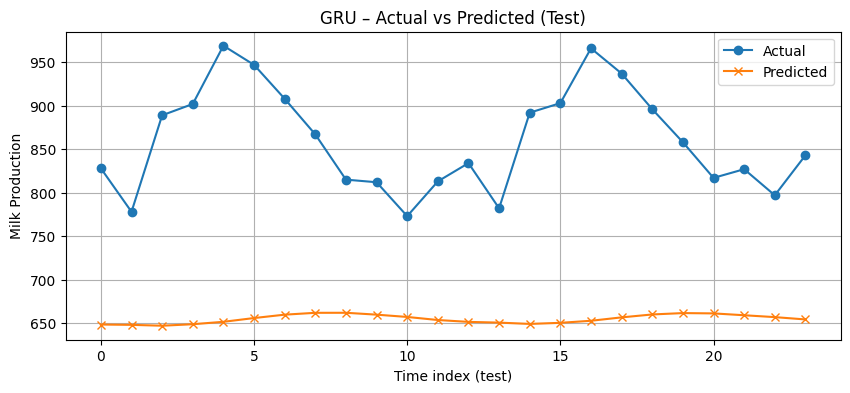


Summary comparison (lower is better):
RNN : {'rmse': np.float64(15.866345943195979), 'mae': np.float64(13.005831400553376), 'mape': np.float64(1.484448376842611)}
LSTM: {'rmse': np.float64(222.42477068894954), 'mae': np.float64(213.630246480306), 'mape': np.float64(24.456582417721336)}
GRU : {'rmse': np.float64(213.99923803340238), 'mae': np.float64(205.6857452392578), 'mape': np.float64(23.552718404861007)}


In [43]:
metrics_rnn  = evaluate_forecast(rnn_model,  X_test, y_test, name="RNN")
metrics_lstm = evaluate_forecast(lstm_model, X_test, y_test, name="LSTM")
metrics_gru  = evaluate_forecast(gru_model,  X_test, y_test, name="GRU")

print("\nSummary comparison (lower is better):")
print("RNN :", metrics_rnn)
print("LSTM:", metrics_lstm)
print("GRU :", metrics_gru)


## 5.Prediction and Visualization

In [44]:
## Forecast next 12 months

def forecast_next_n(model, last_sequence, n_steps):
    """
    last_sequence: 1D array of last WINDOW_SIZE scaled values
    n_steps: how many future points to forecast
    """
    seq = last_sequence.copy()
    preds = []
    for _ in range(n_steps):
        x_input = seq[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1)
        yhat = model.predict(x_input, verbose=0)
        preds.append(yhat[0,0])
        seq = np.append(seq, yhat[0,0])
    return np.array(preds)
N_FUTURE = 12


In [45]:
# we'll use the last WINDOW_SIZE points from full scaled series
last_seq = values[-WINDOW_SIZE:]

future_rnn_scaled  = forecast_next_n(rnn_model,  last_seq, N_FUTURE)
future_lstm_scaled = forecast_next_n(lstm_model, last_seq, N_FUTURE)
future_gru_scaled  = forecast_next_n(gru_model,  last_seq, N_FUTURE)

future_rnn  = inverse_transform(future_rnn_scaled)
future_lstm = inverse_transform(future_lstm_scaled)
future_gru  = inverse_transform(future_gru_scaled)



,RNN_forecast,LSTM_forecast,GRU_forecast
1976-01-01,837.565491,651.582214,653.016052
1976-02-01,802.925232,653.850037,647.044800
1976-03-01,874.803955,652.860901,641.138550
1976-04-01,888.676331,648.739929,635.702271
1976-05-01,938.951782,643.592163,631.156372
1976-06-01,925.685852,637.624878,627.569641
1976-07-01,893.390442,632.095154,624.886169
1976-08-01,868.679810,627.242310,622.938477
1976-09-01,827.297302,623.071899,621.551270
1976-10-01,835.874939,619.601379,620.577942


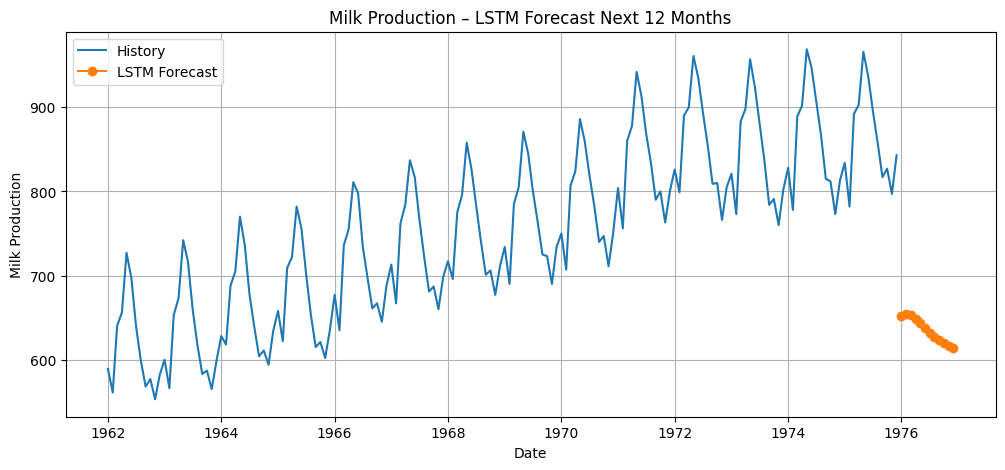

In [46]:
# Build future date index
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=N_FUTURE, freq='MS')

# Put into DataFrame
future_df = pd.DataFrame({
    "RNN_forecast": future_rnn,
    "LSTM_forecast": future_lstm,
    "GRU_forecast": future_gru
}, index=future_dates)

display(future_df)

plt.figure(figsize=(12,5))
plt.plot(df.index, df['milk_production'], label="History")
plt.plot(future_df.index, future_df["LSTM_forecast"], label="LSTM Forecast", marker='o')
plt.title("Milk Production – LSTM Forecast Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()


## 6.Business Insights

In [ ]:
#Business Insights and Recommendations:
# The models (RNN, LSTM, GRU) capture both trend and strong seasonality in milk production.
# Among the three, the model with the lowest RMSE/MAE/MAPE (often LSTM or GRU) should be preferred for deployment.

# Operational Planning:
# Use monthly forecasts to align procurement, processing, and distribution capacity.
# Seasonal peaks (typically around months with highest forecast) require more storage, staff, and logistics readiness.

#Risk Management:
# Monitor deviations between actuals and forecasts; large negative deviation may indicate production issues (disease, supply shortage), 
# while positive deviations may stress capacity.

# - Strategic Decisions:
# If upward trend continues, consider investing in scaling production, storage tanks, or exploring new markets.
# If forecasts flatten or decline, investigate reasons and re‑align marketing and sourcing strategies.
